In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.utils import Sequence
from keras.utils import load_img



2023-01-12 23:31:13.286120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('black_background_500x500.csv')
train_df = df[df['ImagePath'].str.contains("train")]
test_df = df[df['ImagePath'].str.contains("test")]
valid_df = df[df['ImagePath'].str.contains("valid")]

input_size = 500

In [3]:
#########################################################
################## data generator #######################
#########################################################
class datagenerator(tf.keras.utils.Sequence):
    def __init__(self, 
            batch_size, 
            img_size,
            data_paths_df,
            input_channels,
            output_channels):
         
        self.batch_size = batch_size
        self.img_size = img_size
        self.data_paths_df = data_paths_df
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.data_paths = data_paths_df.values[:,1]
        self.params = data_paths_df.values[:,3:6]
        assert len(self.data_paths) == len(self.params)
        
        self.n = len(self.data_paths)

    def on_epoch_end(self):
        'updates indexes after each epoch'
        self.data_paths_df = self.data_paths_df.sample(frac = 1)
        self.data_paths = self.data_paths_df.values[:,1]
        self.params = self.data_paths_df.values[:,3:6]
    
    def __getitem__(self, index):
        batch_data_paths = self.data_paths[index : index + self.batch_size]
        batch_params_paths = self.params[index : index + self.batch_size]

        return self.__dataloader(self.img_size,
                batch_data_paths, batch_params_paths,
                self.input_channels, self.output_channels)
    
    def __len__(self):
        return self.n // self.batch_size

    #################### data loader ########################
    def __dataloader(self, 
            img_size,
            data_paths,
            batch_params_paths,
            input_channels,
            output_channels):
        x = np.zeros((len(data_paths), img_size[0], img_size[1], input_channels))
        y = batch_params_paths
        
        
        for i in range(len(data_paths)):
            data = load_img(path = data_paths[i], grayscale = True)
            data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
            data /= 255
            data.shape = (1,) + data.shape
            x[i] = np.asarray(data)
        return np.array(x).astype("float32"), np.array(y).astype("float32")

In [4]:
inputs = keras.Input(shape=(input_size, input_size, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(3)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                         

In [5]:
import keras.backend as K

def abs_loss_function(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    return K.mean(minimum_from_two)

def square_abs_min_loss(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    result = tf.math.square( (minimum_from_two[:, 0] + minimum_from_two[:, 1] + minimum_from_two[:, 2]) / 3 )
    return K.mean(result)

def square_abs_min_individual_loss(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    result = (tf.math.square(minimum_from_two[:, 0]) + 
              tf.math.square(minimum_from_two[:, 1]) + 
              tf.math.square(minimum_from_two[:, 2])) / 3 
    return K.mean(result)

############################# For debugging ####################################
#     print("_________________ 1 __________________")
#     print(abs_diff_reversed.numpy())
#     print("_________________ 2 __________________")
#     print(abs_diff.numpy())

In [6]:
model.compile(optimizer = 'sgd',
              loss = square_abs_min_loss, 
              metrics = ['accuracy'],
              run_eagerly = True)  # Add run_eagerly=True to enable the numpy debugging

tg = datagenerator(32, (input_size,input_size), train_df, 1, 3)
vg = datagenerator(32, (input_size,input_size), valid_df, 1, 3)

In [7]:
history = model.fit(x=tg,
                    batch_size=32,
                    epochs=2,
                    validation_data=vg)

/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Epoch 1/2
273/273 [==============================] - 696s 3s/step - loss: 0.0651 - accuracy: 0.3142 - val_loss: 0.0755 - val_accuracy: 0.2923
Epoch 2/2
273/273 [==============================] - 728s 3s/step - loss: 0.0657 - accuracy: 0.2873 - val_loss: 0.0742 - val_accuracy: 0.3800


In [8]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'],'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'],'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.savefig("graph_{}_{}_{}_{}.png".format(input_size,input_size,input_size,input_size))
    

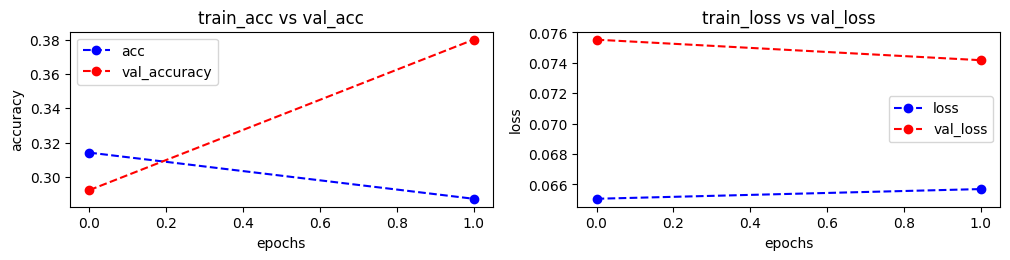

In [9]:
plot_accuracy_loss(history)


In [10]:
tg = datagenerator(32, (input_size,input_size), test_df, 1, 3)
results = model.evaluate(tg, batch_size=32)
print("test loss, test acc:", results)

31/31 [==============================] - 26s 834ms/step - loss: 0.0792 - accuracy: 0.4012
test loss, test acc: [0.07920745015144348, 0.40120968222618103]


In [11]:
predictions = model.predict(tg)  
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

31/31 [==============================] - 27s 871ms/step


In [19]:
t = test_df.values[45][1]
data = load_img(path = t, grayscale = True)
data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
data /= 255
data.shape = (1,) + data.shape
X = np.asarray(data)

print(t)
yhat = model.predict(data)
print(yhat*90)

Database/black_background_500x500/test/4b971de4894311edbcfa0894ef90a40a_61.5_84.0_82.4.png
1/1 [==============================] - 0s 36ms/step
[[ 18.244368 -18.929392  24.787104]]


In [12]:
model_name = "one"
model.save("Models/{}.h5".format(model_name), save_format = 'h5')

In [ ]:
del model 

In [15]:
from keras.models import load_model 
from tensorflow.keras.utils import CustomObjectScope

with CustomObjectScope({'square_abs_min_loss': square_abs_min_loss}):
    model2 = keras.models.load_model('Models/one.h5')


In [26]:
def prdict_and_print(nr):
    t = test_df.values[nr][1]
    data = load_img(path = t, grayscale = True)
    data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
    data /= 255
    data.shape = (1,) + data.shape
    X = np.asarray(data)
    print("----------{}----------".format(nr))
    euler = t.split("_")
    print("phi1", float(euler[3])*90)
    print("PHI",   float(euler[4])*90)
    print("phi2",  float(euler[5][:-4])*90)
    yhat = model.predict(data)
    print("predicted values", yhat*90)

    
print("############### PREDICTIONS ###############")
for i in range(10):
    prdict_and_print(i)
print("############### PREDICTIONS ###############")

############### PREDICTIONS ###############
----------0----------
phi1 4923.0
PHI 3249.0
phi2 2115.0
1/1 [==============================] - 0s 37ms/step
predicted values [[ 19.81702  -22.103527  28.706423]]
----------1----------
phi1 6840.0
PHI 7533.0
phi2 261.0
1/1 [==============================] - 0s 36ms/step
predicted values [[ 18.607037 -19.564367  25.411297]]
----------2----------
phi1 1602.0
PHI 5742.0
phi2 4572.0
1/1 [==============================] - 0s 35ms/step
predicted values [[ 20.062462 -22.186863  28.735647]]
----------3----------
phi1 1575.0
PHI 1395.0
phi2 4536.0
1/1 [==============================] - 0s 35ms/step
predicted values [[ 18.756674 -19.738184  25.702429]]
----------4----------
phi1 4275.0
PHI 2934.0
phi2 2682.0
1/1 [==============================] - 0s 36ms/step
predicted values [[ 18.447622 -19.159582  25.080746]]
----------5----------
phi1 2996.9999999999995
PHI 3564.0
phi2 2565.0
1/1 [==============================] - 0s 37ms/step
predicted values [[ 1